**Created on Fri Sep 27 14:58:20 2019**


normJBtest(a)   <-- Jarque-Bera test
hausman(fe, re) <-- Hausman test for IV estimates (not FE vs RE)
tabstat(n,d)      <-- descriptive statiastics

In [3]:
import numpy as np
from scipy import stats
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.sandbox.regression.gmm import IVRegressionResults
import matplotlib.pyplot as plt
import seaborn as sns
# "summary_col" is not compatible with the following  !!! >>
from linearmodels.iv import IV2SLS as iv4sarg
from linearmodels.iv import compare

In [2]:
# определение функций

def normJBtest(a):
    """
    The Jarque-Bera test with a null that the sample data
      has the skewness and kurtosis matching a normal distribution.
    This test asymptotically has
      a Chi-squared distribution with 2 degrees of freedom.
    """
    obs = len(a)
    stat, p = np.round(stats.jarque_bera(a), 3)
    alpha = 0.1
    if p > alpha:
        st = '10% significance level)'
        msg='Sample looks Gaussian (fail to reject H0 at ' + st
        stars = ' '
        return (obs, stat, stars, p, msg)
    else:
        alpha = 0.05
        if p > alpha:
            st = '10% significance level)'
            msg = 'H0 is rejected at ' + st
            stars = '*'
            return (obs, stat, stars, p, msg)
        else:
            alpha = 0.01
            if p > alpha:
                st = '5% significance level)'
                msg = 'H0 is rejected at ' + st
                stars = '**'
                return (obs, stat, stars, p, msg)
            else:
                st = '1% significance level)'
                msg = 'H0 is rejected at ' + st
                stars = '***'
                return (obs, stat, stars, p, msg)


def hausman(fe, re):
    """
    This is from
    https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py
    by Spencer Lyon with my corrections...

    Hausman test for fixed effects/random effects models
    
    b is obtained from FE (or IV):
        b = beta_fe
    B is obtained from RE (or OLS):
        B = beta_re

    From theory we have that
    b is consistent under the null (Ho) and alternative hypothesis (Ha),
    B is inconsistent under Ha, efficient under Ho.

    The test statistic is computed as

    chi2 = (b - B)' [V_b - v_B]^{-1} (b - B)

    The statistic is distributed chi2 \sim \chi^2(k),
    where k is the degrees of freedom for the Hausman test.
    The default is the matrix rank of the variance of the difference
    between the coefficients of the two estimators.

    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.

    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.

    Returns
    =======
    chi2 : float
        The test statistic

    df : int
        The number of degrees of freedom for the distribution of the
        test statistic

    pval : float
        The p-value associated with the null hypothesis

    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.

    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov_params()
    v_B = re.cov_params()

    """
    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    df = b[np.abs(b) < 1e8].size
    """
    # this works for IV !!! >>
    df = np.linalg.matrix_rank(np.cov((v_b - v_B),(v_b - v_B)))

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    pval = np.round(stats.chi2.sf(chi2, df), 3)
    chi2 = np.round(chi2, 2)

    print('\nHausman test >>>',
          '\n   Ho: difference in coefficients not systematic',
          '\n chi2(',df,') =\t', chi2,'\n Prob>chi2 =\t', pval,'\n')

    return chi2, df, pval


def tabstat(n,d):
    """
    Descriptive statiastics
    """
    return np.round(d.describe().T[['count',
                                   'mean', 'std', 'min', 'max']], n)

In [14]:
df = pd.read_stata("sch.dta")

In [17]:
df=df.dropna(subset=['lincr_','edus','edus_sp','id_sp_dyad',
                     'wage_1r','edus_fth','edus_mth'])
min_age=17
max_age=72
df=df[(df.age >= min_age) & (df.age <= max_age)]

In [18]:
for key in ['lincr_','wage_1r','edus', 'edus_sp','edus_fth','edus_mth']:
    print(key,'   \t<-> ',labels.variable_labels()[key])

lincr_    	<->  Log( Income )
wage_1r    	<->  Wage, job 1, real
edus    	<->  Education
edus_sp    	<->  Spouse's education
edus_fth    	<->  Father's education
edus_mth    	<->  Mother's education


In [19]:
df[['lincr_','wage_1r','edus', 'edus_sp','edus_fth','edus_mth']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5207 entries, 0 to 6586
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   lincr_    5207 non-null   float32 
 1   wage_1r   5207 non-null   float32 
 2   edus      5207 non-null   category
 3   edus_sp   5207 non-null   category
 4   edus_fth  5207 non-null   category
 5   edus_mth  5207 non-null   category
dtypes: category(4), float32(2)
memory usage: 102.4 KB


In [20]:
for key in ['edus', 'edus_sp','edus_fth','edus_mth']:
    print('\n',pd.crosstab(df[key], columns=[key], dropna=False))



 col_0                       edus
edus                            
Secondary school             686
Vocational training school  1161
Technical college           1467
University                  1893

 col_0                       edus_sp
edus_sp                            
Secondary school                756
Vocational training school     1183
Technical college              1437
University                     1831

 col_0                       edus_fth
edus_fth                            
Secondary school                1792
Vocational training school      1716
Technical college                865
University                       834

 col_0                       edus_mth
edus_mth                            
Secondary school                2018
Vocational training school      1038
Technical college               1352
University                       799


In [21]:
for key in ['edus_sp1','edus_sp2','edus_sp3','edus_sp4']:
    print('\n',pd.crosstab(df.edus_sp, df[key],
                           margins=True, margins_name="Total"))


 edus_sp1                       0    1  Total
edus_sp                                     
Secondary school               0  756    756
Vocational training school  1183    0   1183
Technical college           1437    0   1437
University                  1831    0   1831
Total                       4451  756   5207

 edus_sp2                       0     1  Total
edus_sp                                      
Secondary school             756     0    756
Vocational training school     0  1183   1183
Technical college           1437     0   1437
University                  1831     0   1831
Total                       4024  1183   5207

 edus_sp3                       0     1  Total
edus_sp                                      
Secondary school             756     0    756
Vocational training school  1183     0   1183
Technical college              0  1437   1437
University                  1831     0   1831
Total                       3770  1437   5207

 edus_sp4                       0 

In [22]:
pd.crosstab(df.edus_mth, df.edus_mth4, margins=True, margins_name="Total")

edus_mth4,0,1,Total
edus_mth,,,
Secondary school,2018,0,2018
Vocational training school,1038,0,1038
Technical college,1352,0,1352
University,0,799,799
Total,4408,799,5207


In [23]:
for key in ['edus', 'edus_sp','edus_fth','edus_mth']:
    key2=key+'_'
    df[key2] = 1+pd.factorize(df[key], sort=True)[0]
    print('\n',pd.crosstab(df[key], df[key2],
                           margins=True, margins_name="Total"))


 edus_                         1     2     3     4  Total
edus                                                    
Secondary school            686     0     0     0    686
Vocational training school    0  1161     0     0   1161
Technical college             0     0  1467     0   1467
University                    0     0     0  1893   1893
Total                       686  1161  1467  1893   5207

 edus_sp_                      1     2     3     4  Total
edus_sp                                                 
Secondary school            756     0     0     0    756
Vocational training school    0  1183     0     0   1183
Technical college             0     0  1437     0   1437
University                    0     0     0  1831   1831
Total                       756  1183  1437  1831   5207

 edus_fth_                      1     2    3    4  Total
edus_fth                                               
Secondary school            1792     0    0    0   1792
Vocational training school  

In [24]:
# Descriptive statistics >>

np.round(df[['edus_', 'edus_sp_',
             'edus_fth_','edus_mth_']].describe().T[['count',
                                   'mean', 'std', 'min', 'max']], 2)

,count,mean,std,min,max
edus_,5207.0,2.88,1.05,1.0,4.0
edus_sp_,5207.0,2.83,1.06,1.0,4.0
edus_fth_,5207.0,2.14,1.06,1.0,4.0
edus_mth_,5207.0,2.18,1.11,1.0,4.0


<AxesSubplot:xlabel='edus_sp_', ylabel='edus_'>

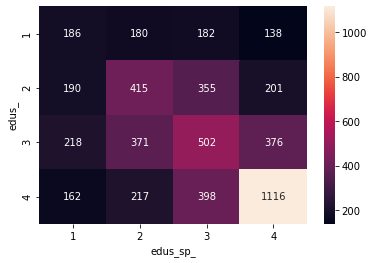

In [25]:
# two-way tabulation >>>
pd.crosstab(df.edus_, df.edus_sp_, margins=True, margins_name="Total")
sns.heatmap(pd.crosstab(df.edus_, df.edus_sp_),annot=True, fmt="d")


<AxesSubplot:xlabel='edus_fth_', ylabel='edus_'>

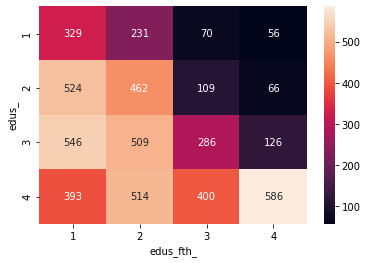

In [26]:
pd.crosstab(df.edus_, df.edus_fth_, margins=True, margins_name="Total")
sns.heatmap(pd.crosstab(df.edus_, df.edus_fth_),annot=True, fmt="d")

<AxesSubplot:xlabel='edus_mth_', ylabel='edus_'>

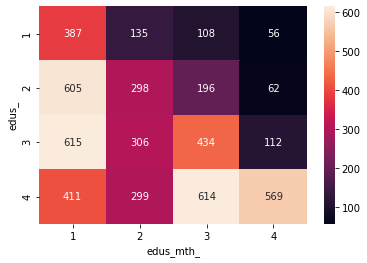

In [27]:
pd.crosstab(df.edus_, df.edus_mth_, margins=True, margins_name="Total")
sns.heatmap(pd.crosstab(df.edus_, df.edus_mth_),annot=True, fmt="d")

<AxesSubplot:xlabel='edus_mth_', ylabel='edus_fth_'>

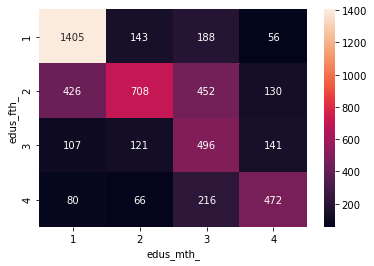

In [28]:
pd.crosstab(df.edus_fth_, df.edus_mth_, margins=True, margins_name="Total")
sns.heatmap(pd.crosstab(df.edus_fth_, df.edus_mth_),annot=True, fmt="d")

In [29]:
# OLS >>
df['Intercept'] = 1
dep = df['lincr_']
expl = df[['edus2', 'edus3', 'edus4', 'Intercept']]
ols = sm.OLS(dep, expl).fit()

# Testing for relevant (strong) instruments >>
expl_ = df[['edus_sp2', 'edus_sp3', 'edus_sp4', 'Intercept']]
hyp = 'edus_sp2 = edus_sp3 = edus_sp4 = 0'
ols2 = sm.OLS(df['edus2'], expl_).fit()
f_test2 = ols2.f_test(hyp)
ols3 = sm.OLS(df['edus3'], expl_).fit()
f_test3 = ols3.f_test(hyp)
ols4 = sm.OLS(df['edus4'], expl_).fit()
f_test4 = ols4.f_test(hyp)
print('\nTesting for strong (relevant) instruments >>',
      '\n edus2 :', f_test2, '\n edus3 :', f_test3,
      '\n edus4 :', f_test4)
"""
print('\n',ols2.summary())
"""



Testing for strong (relevant) instruments >> 
 edus2 : <F test: F=array([[89.42061517]]), p=2.0261506473075035e-56, df_denom=5.2e+03, df_num=3> 
 edus3 : <F test: F=array([[30.96919452]]), p=7.765467487027888e-20, df_denom=5.2e+03, df_num=3> 
 edus4 : <F test: F=array([[298.19564854]]), p=1.2292298805558019e-178, df_denom=5.2e+03, df_num=3>


"\nprint('\n',ols2.summary())\n"

In [30]:
# Testing for relevant (strong) instruments >>
expl_a = df[['edus_sp2', 'edus_sp3', 'edus_sp4',
            'edus_fth2', 'edus_fth3', 'edus_fth4',
            'edus_mth2', 'edus_mth3', 'edus_mth4','Intercept']]
hypa = 'edus_sp2=edus_sp3=edus_sp4=edus_fth2=edus_fth3=edus_fth4=edus_mth2=edus_mth3=edus_mth4=0'
ols2a = sm.OLS(df['edus2'], expl_a).fit()
f_test2a = ols2a.f_test(hyp)
ols3a = sm.OLS(df['edus3'], expl_a).fit()
f_test3a = ols3a.f_test(hyp)
ols4a = sm.OLS(df['edus4'], expl_a).fit()
f_test4a = ols4a.f_test(hyp)
print('\nTesting for strong (relevant) instruments >>',
      '\n edus2 :', f_test2a, '\n edus3 :', f_test3a,
      '\n edus4 :', f_test4a)


Testing for strong (relevant) instruments >> 
 edus2 : <F test: F=array([[54.1404223]]), p=1.8787717667299339e-34, df_denom=5.2e+03, df_num=3> 
 edus3 : <F test: F=array([[20.87342529]]), p=1.940810512027587e-13, df_denom=5.2e+03, df_num=3> 
 edus4 : <F test: F=array([[186.19912742]]), p=1.1032452869309548e-114, df_denom=5.2e+03, df_num=3>


In [38]:
# IV  >>
instr = df[['edus_sp2', 'edus_sp3', 'edus_sp4', 'Intercept']]
ivsp = IV2SLS(dep, expl, instr).fit()


# GIV  >>
instra = df[['edus_sp2', 'edus_sp3', 'edus_sp4',
            'edus_fth2', 'edus_fth3', 'edus_fth4',
            'edus_mth2', 'edus_mth3', 'edus_mth4', 'Intercept']]
iva = IV2SLS(dep, expl, instra).fit()


# GIVfm  >>
instrfm = df[['edus_fth2', 'edus_fth3', 'edus_fth4',
            'edus_mth2', 'edus_mth3', 'edus_mth4', 'Intercept']]
ivfm = IV2SLS(dep, expl, instrfm).fit()


# RESULTS  >>
info_dict={'Observations' : lambda x: f"{int(x.nobs):d}",
        'Adj. R-sq.' : lambda x: f"{x.rsquared_adj:.3f}",
        'F' : lambda x: x.fvalue,
        'F p-value' : lambda x: x.f_pvalue}
results_table = summary_col(results=[ols,ivsp,iva,ivfm],
                float_format='%0.3f',
                stars = True, info_dict=info_dict,
                model_names=['OLS','IV','GIV','GIVfm'],
                regressor_order=df.columns.tolist())
print('\n', results_table,
      '\n',labels.variable_labels()['edus1'], 'is a base category',
      '\n edus2 <->',labels.variable_labels()['edus2'],
      '\n edus3 <->',labels.variable_labels()['edus3'],
      '\n edus4 <->',labels.variable_labels()['edus4'])


 
                 OLS       IV      GIV     GIVfm  
--------------------------------------------------
edus2          0.018    0.671*   0.868*** 0.380   
               (0.032)  (0.399)  (0.332)  (0.711) 
edus3          0.034    1.191*** 0.343    -0.211  
               (0.031)  (0.389)  (0.248)  (0.447) 
edus4          0.311*** 1.388*** 1.172*** 0.730   
               (0.030)  (0.248)  (0.214)  (0.455) 
Intercept      9.442*** 8.578*** 8.852*** 9.278***
               (0.025)  (0.242)  (0.206)  (0.440) 
R-squared      0.042    -0.280   -0.195   -0.137  
R-squared Adj. 0.041    -0.280   -0.195   -0.137  
Observations   5207     5207     5207     5207    
Adj. R-sq.     0.041    -0.280   -0.195   -0.137  
F              75.9623  56.0547  79.6759  46.8063 
F p-value      0.0000   0.0000   0.0000   0.0000  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01 
 Secondary school is a base category 
 edus2 <-> Vocational training school 
 edus3 <-> Technical college 
 edus4 <-> Uni

In [40]:
## Tests of endogeneity of: edus2 edus3 edus4  >>>>>
#
# Hausman test: >>
# Statistic is somewhat higher than in Stata !!! >>>
H_testsp = IVRegressionResults.spec_hausman(ivsp)
H_testa = IVRegressionResults.spec_hausman(iva)
print('\nHausman test: ', H_testsp,'\n',H_testa)


Hausman test:  (102.68984048361527, 4.1025826772205755e-22, 3) 
 (128.86792686982687, 9.484826968022957e-28, 3)


In [41]:
hausman(ivsp,ols)


Hausman test >>> 
   Ho: difference in coefficients not systematic 
 chi2( 3 ) =	 73.86 
 Prob>chi2 =	 0.0 



(73.86, 3, 0.0)

In [42]:
hausman(iva,ols)


Hausman test >>> 
   Ho: difference in coefficients not systematic 
 chi2( 3 ) =	 97.15 
 Prob>chi2 =	 0.0 



(97.15, 3, 0.0)

In [43]:
# Sargan test ... >>>
#
exog=df['Intercept']
endog=df[['edus2', 'edus3', 'edus4']]
instruments=df[['edus_sp2', 'edus_sp3', 'edus_sp4',
            'edus_fth2', 'edus_fth3', 'edus_fth4',
            'edus_mth2', 'edus_mth3', 'edus_mth4']]
instruments2=df[['edus_fth2', 'edus_fth3', 'edus_fth4',
        'edus_mth2', 'edus_mth3', 'edus_mth4']]
# The default cov_type is 'robust' (robust to heteroskedasticity) >>
# 'unadjusted' is the classic homoskedastic estimator >>
ivsplm = iv4sarg(dep, exog, endog, instruments).fit(cov_type='unadjusted')
ivsplm2 = iv4sarg(dep, exog, endog, instruments2).fit(cov_type='unadjusted')
print(compare({'GIV':ivsplm, 'GIVfm':ivsplm2}, precision='pvalues'),
      '\n\n',compare({'GIV':ivsplm, 'GIVfm':ivsplm2}, precision='std-errors'))
print('\nGIV >>>\n',ivsplm.sargan,'\n\nGIVfm >>>\n',ivsplm2.sargan)

                  Model Comparison                 
                                 GIV          GIVfm
---------------------------------------------------
Dep. Variable                 lincr_         lincr_
Estimator                    IV-2SLS        IV-2SLS
No. Observations                5207           5207
Cov. Est.                 unadjusted     unadjusted
R-squared                    -0.1947        -0.1367
Adj. R-squared               -0.1954        -0.1373
F-statistic                   239.21         140.53
P-value (F-stat)              0.0000         0.0000
==================     =============   ============
Intercept                     8.8519         9.2775
                            (0.0000)       (0.0000)
edus2                         0.8677         0.3798
                            (0.0090)       (0.5928)
edus3                         0.3435        -0.2106
                            (0.1659)       (0.6376)
edus4                         1.1719         0.7296
            

In [44]:
"""
print(ivsplm)
"""
"""
* A statistically significant test statistic always indicates that
* the instruments may not be valid	!!!	>>>
 
 Compare with the Stata results... >>
 
Tests of overidentifying restrictions:
Sargan N*R-sq test       15.415  Chi-sq(6)    P-value = 0.0173
Basmann test             15.431  Chi-sq(6)    P-value = 0.0172
"""

'\n* A statistically significant test statistic always indicates that\n* the instruments may not be valid\t!!!\t>>>\n \n Compare with the Stata results... >>\n \nTests of overidentifying restrictions:\nSargan N*R-sq test       15.415  Chi-sq(6)    P-value = 0.0173\nBasmann test             15.431  Chi-sq(6)    P-value = 0.0172\n'

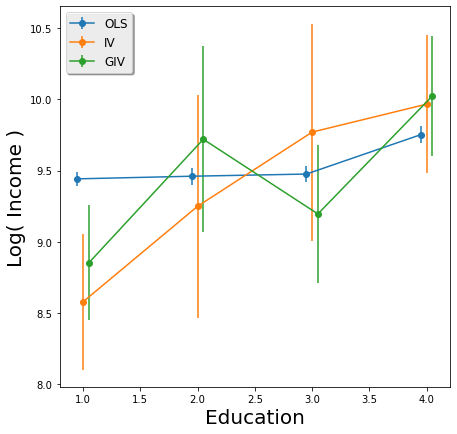

In [45]:
delta=.05
od = {'x': [1-delta, 2-delta, 3-delta, 4-delta],
     'y': [ols.params.Intercept, ols.params.Intercept+ols.params.edus2,
           ols.params.Intercept+ols.params.edus3,
           ols.params.Intercept+ols.params.edus4],
     'err': [1.96*ols.HC0_se.Intercept, 1.96*ols.HC0_se.edus2,
             1.96*ols.HC0_se.edus3, 1.96*ols.HC0_se.edus4]}
odm = pd.DataFrame(data=od)

odi = {'x': [1, 2, 3, 4],
     'y': [ivsp.params.Intercept, ivsp.params.Intercept+ivsp.params.edus2,
           ivsp.params.Intercept+ivsp.params.edus3,
           ivsp.params.Intercept+ivsp.params.edus4],
     'err': [1.96*ivsp.params.Intercept/ivsp.tvalues.Intercept,
             1.96*ivsp.params.edus2/ivsp.tvalues.edus2,
             1.96*ivsp.params.edus3/ivsp.tvalues.edus3,
             1.96*ivsp.params.edus4/ivsp.tvalues.edus4]}
odmi = pd.DataFrame(data=odi)

odia = {'x': [1+delta, 2+delta, 3+delta, 4+delta],
     'y': [iva.params.Intercept, iva.params.Intercept+iva.params.edus2,
           iva.params.Intercept+iva.params.edus3,
           iva.params.Intercept+iva.params.edus4],
     'err': [1.96*iva.params.Intercept/iva.tvalues.Intercept,
             1.96*iva.params.edus2/iva.tvalues.edus2,
             1.96*iva.params.edus3/iva.tvalues.edus3,
             1.96*iva.params.edus4/iva.tvalues.edus4]}
odmia = pd.DataFrame(data=odia)

## run all the lines together >>
plt.figure(figsize=(7,7))
plt.errorbar(odm['x'], odm['y'], yerr=odm['err'], fmt='-o', label='OLS')
plt.errorbar(odmi['x'], odmi['y'], yerr=odmi['err'], fmt='-o', label='IV')
plt.errorbar(odmia['x'], odmia['y'], yerr=odmia['err'], fmt='-o', label='GIV')
plt.ylabel(labels.variable_labels()['lincr_'], fontsize=20)
plt.xlabel(labels.variable_labels()['edus'], fontsize=20)
plt.legend(loc='upper left', shadow=True, fontsize='large', framealpha=.8)

In [46]:
print('\nEducation:','\n 1 -',labels.variable_labels()['edus1'],
      '\n 2 -',labels.variable_labels()['edus2'],
      '\n 3 -',labels.variable_labels()['edus3'],
      '\n 4 -',labels.variable_labels()['edus4'])

#
 # t-tests & F-tests vs marginal effects plot  !!!  >>>
#
print('\n', results_table,
      '\n',labels.variable_labels()['edus1'], 'is a base category',
      '\n edus2 <->',labels.variable_labels()['edus2'],
      '\n edus3 <->',labels.variable_labels()['edus3'],
      '\n edus4 <->',labels.variable_labels()['edus4'])
print(ols.f_test('Intercept + edus4 = Intercept'))
print(ivsp.f_test('Intercept + edus2 = Intercept'))
print(ivsp.f_test('edus2 = edus3'))
print(iva.f_test('Intercept + edus2 = Intercept'))
print(iva.f_test('edus2 = edus3'))
print(iva.f_test('edus3 = edus4'))
print(iva.f_test('edus2 = edus4'))


Education: 
 1 - Secondary school 
 2 - Vocational training school 
 3 - Technical college 
 4 - University

 
                 OLS       IV      GIV     GIVfm  
--------------------------------------------------
edus2          0.018    0.671*   0.868*** 0.380   
               (0.032)  (0.399)  (0.332)  (0.711) 
edus3          0.034    1.191*** 0.343    -0.211  
               (0.031)  (0.389)  (0.248)  (0.447) 
edus4          0.311*** 1.388*** 1.172*** 0.730   
               (0.030)  (0.248)  (0.214)  (0.455) 
Intercept      9.442*** 8.578*** 8.852*** 9.278***
               (0.025)  (0.242)  (0.206)  (0.440) 
R-squared      0.042    -0.280   -0.195   -0.137  
R-squared Adj. 0.041    -0.280   -0.195   -0.137  
Observations   5207     5207     5207     5207    
Adj. R-sq.     0.041    -0.280   -0.195   -0.137  
F              75.9623  56.0547  79.6759  46.8063 
F p-value      0.0000   0.0000   0.0000   0.0000  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01 
 Secondary s

In [47]:
# just the same by another base category >>>
# GIV...  >>
expl2 = df[['edus1', 'edus2', 'edus4', 'Intercept']]
iva2 = IV2SLS(dep, expl2, instra).fit()
expl3 = df[['edus1', 'edus3', 'edus4', 'Intercept']]
iva3 = IV2SLS(dep, expl3, instra).fit()
results_table = summary_col(results=[ols,ivsp,iva,iva2,iva3],
                float_format='%0.3f',
                stars = True, info_dict=info_dict,
                model_names=['OLS','IV','GIV','GIV2','GIV3'],
                regressor_order=df.columns.tolist())
print('\n', results_table,
      '\n',labels.variable_labels()['edus1'], 'is a base category',
      '\n edus2 <->',labels.variable_labels()['edus2'],
      '\n edus3 <->',labels.variable_labels()['edus3'],
      '\n edus4 <->',labels.variable_labels()['edus4'])


 
                 OLS       IV      GIV      GIV2      GIV3  
------------------------------------------------------------
edus1                                     -0.343   -0.868***
                                          (0.248)  (0.332)  
edus2          0.018    0.671*   0.868*** 0.524**           
               (0.032)  (0.399)  (0.332)  (0.261)           
edus3          0.034    1.191*** 0.343             -0.524** 
               (0.031)  (0.389)  (0.248)           (0.261)  
edus4          0.311*** 1.388*** 1.172*** 0.828*** 0.304**  
               (0.030)  (0.248)  (0.214)  (0.153)  (0.147)  
Intercept      9.442*** 8.578*** 8.852*** 9.195*** 9.720*** 
               (0.025)  (0.242)  (0.206)  (0.126)  (0.160)  
R-squared      0.042    -0.280   -0.195   -0.195   -0.195   
R-squared Adj. 0.041    -0.280   -0.195   -0.195   -0.195   
Observations   5207     5207     5207     5207     5207     
Adj. R-sq.     0.041    -0.280   -0.195   -0.195   -0.195   
F              75.962

C:\Users\demen\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\demen\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\demen\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\demen\anaconda3\lib\site-packages\seaborn\distributions.py:1668: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


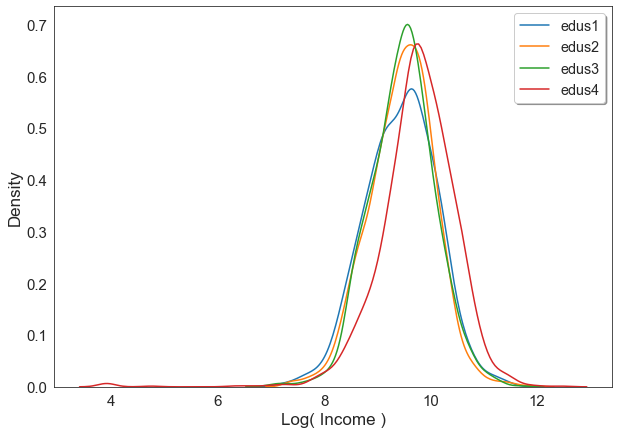

In [48]:
# t-tests & F-tests vs marginal effects plot  !!!  <<<
 #

# kernel density... >>>
k="epa"
k="gau"
sns.set_style("white")
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax = sns.kdeplot(df['lincr_'][df['edus_']==1], label='edus1', kernel=k)
ax = sns.kdeplot(df['lincr_'][df['edus_']==2], label='edus2', kernel=k)
ax = sns.kdeplot(df['lincr_'][df['edus_']==3], label='edus3', kernel=k)
ax = sns.kdeplot(df['lincr_'][df['edus_']==4], label='edus4', kernel=k)
plt.ylabel('Density', fontsize=17)
plt.xlabel(labels.variable_labels()['lincr_'], fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(shadow=True, fontsize='x-large')